In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
DATA_DIR = "/content/drive/MyDrive/2023DeepLearning/UTKFace"
#DATA_DIR = "/content/data"
TRAIN_TEST_SPLIT = 0.7
IM_WIDTH = IM_HEIGHT = 198
ID_GENDER_MAP = {0: 'male', 1: 'female'}
GENDER_ID_MAP = dict((g, i) for i, g in ID_GENDER_MAP.items())
ID_RACE_MAP = {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'}
RACE_ID_MAP = dict((r, i) for i, r in ID_RACE_MAP.items())

ID_GENDER_MAP, GENDER_ID_MAP, ID_RACE_MAP, RACE_ID_MAP

({0: 'male', 1: 'female'},
 {'male': 0, 'female': 1},
 {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'},
 {'white': 0, 'black': 1, 'asian': 2, 'indian': 3, 'others': 4})

In [9]:
def parse_filepath(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        age, gender, race, _ = filename.split("_")
        return int(age), ID_GENDER_MAP[int(gender)], ID_RACE_MAP[int(race)]
    except Exception as e:
        print(filepath)
        return None, None, None

In [10]:
# create a pandas data frame of images, age, gender and race
files = glob.glob(os.path.join(DATA_DIR, "*.jpg"))

In [11]:
attributes = list(map(parse_filepath, files))

/content/drive/MyDrive/2023DeepLearning/UTKFace/61_1_20170109150557335.jpg.chip.jpg
/content/drive/MyDrive/2023DeepLearning/UTKFace/61_1_20170109142408075.jpg.chip.jpg
/content/drive/MyDrive/2023DeepLearning/UTKFace/39_1_20170116174525125.jpg.chip.jpg


In [12]:
df = pd.DataFrame(attributes)
df['file'] = files
print(df.size)
df.columns = ['age', 'gender', 'race', 'file']
df = df.dropna()
df.head()

94872


,age,gender,race,file
0,80.0,male,asian,/content/drive/MyDrive/2023DeepLearning/UTKFac...
1,80.0,male,asian,/content/drive/MyDrive/2023DeepLearning/UTKFac...
2,80.0,male,asian,/content/drive/MyDrive/2023DeepLearning/UTKFac...
3,80.0,male,black,/content/drive/MyDrive/2023DeepLearning/UTKFac...
4,80.0,male,asian,/content/drive/MyDrive/2023DeepLearning/UTKFac...


In [13]:
df.describe()

,age
count,23715.000000
mean,33.301623
std,19.881545
min,1.000000
25%,23.000000
50%,29.000000
75%,45.000000
max,116.000000


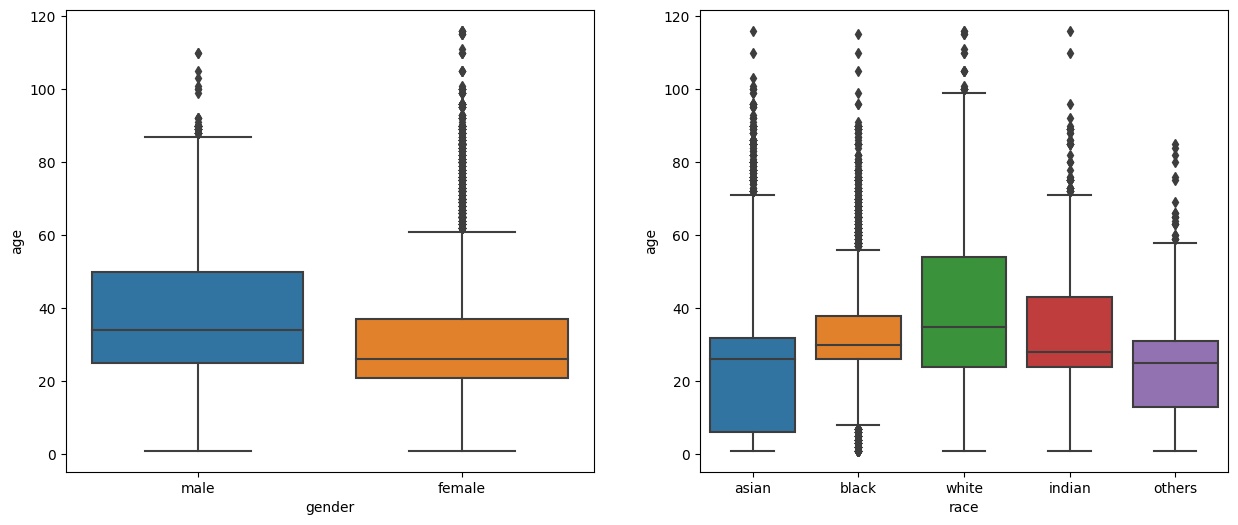

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
_ = sns.boxplot(data=df, x='gender', y='age', ax=ax1)
_ = sns.boxplot(data=df, x='race', y='age', ax=ax2)

<Axes: xlabel='gender', ylabel='age'>

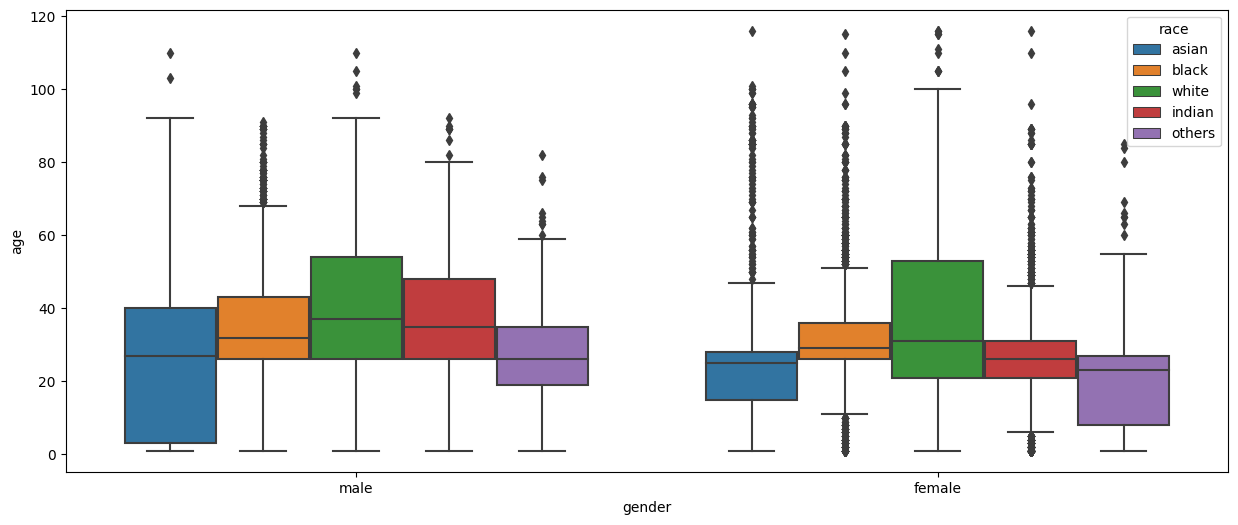

In [15]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x='gender', y='age', hue='race')

<Axes: xlabel='race,gender'>

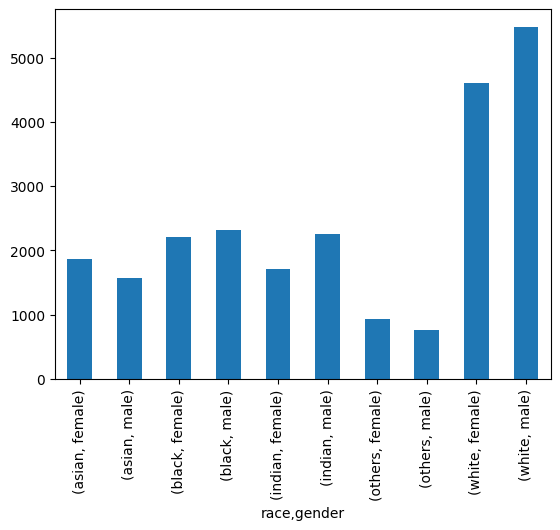

In [16]:
df.groupby(by=['race', 'gender'])['age'].count().plot(kind='bar')

<Axes: >

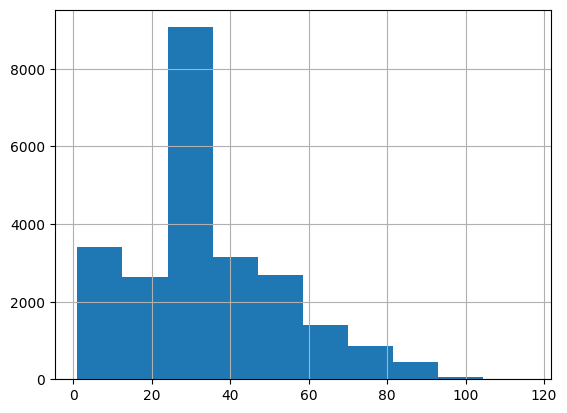

In [17]:
df['age'].hist()

In [18]:
df['age'].describe()

count    23715.000000
mean        33.301623
std         19.881545
min          1.000000
25%         23.000000
50%         29.000000
75%         45.000000
max        116.000000
Name: age, dtype: float64

In [19]:
df = df[(df['age'] > 10) & (df['age'] < 65)]

In [20]:
p = np.random.permutation(len(df))
train_up_to = int(len(df) * TRAIN_TEST_SPLIT)
train_idx = p[:train_up_to]
test_idx = p[train_up_to:]

# split train_idx further into training and validation set
train_up_to = int(train_up_to * 0.7)
train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]

df['gender_id'] = df['gender'].map(lambda gender: GENDER_ID_MAP[gender])
df['race_id'] = df['race'].map(lambda race: RACE_ID_MAP[race])

max_age = df['age'].max()
len(train_idx), len(valid_idx), len(test_idx), max_age

<ipython-input-20-5a78acd6edfb>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender_id'] = df['gender'].map(lambda gender: GENDER_ID_MAP[gender])
<ipython-input-20-5a78acd6edfb>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['race_id'] = df['race'].map(lambda race: RACE_ID_MAP[race])


(9083, 3894, 5562, 64.0)

In [21]:
from keras.utils import to_categorical
from PIL import Image

def get_data_generator(df, indices, for_training, batch_size=16):
    images, ages, races, genders = [], [], [], []
    while True:
        for i in indices:
            r = df.iloc[i]
            file, age, race, gender = r['file'], r['age'], r['race_id'], r['gender_id']
            im = Image.open(file)
            im = im.resize((IM_WIDTH, IM_HEIGHT))
            im = np.array(im) / 255.0
            images.append(im)
            ages.append(age / max_age)
            races.append(to_categorical(race, len(RACE_ID_MAP)))
            genders.append(to_categorical(gender, 2))
            if len(images) >= batch_size:
                yield np.array(images), [np.array(ages), np.array(races), np.array(genders)]
                images, ages, races, genders = [], [], [], []
        if not for_training:
            break

In [22]:
from keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from keras.optimizers import SGD
from keras.models import Model

def conv_block(inp, filters=32, bn=True, pool=True):
    _ = Conv2D(filters=filters, kernel_size=3, activation='relu')(inp)
    if bn:
        _ = BatchNormalization()(_)
    if pool:
        _ = MaxPool2D()(_)
    return _

input_layer = Input(shape=(IM_HEIGHT, IM_WIDTH, 3))
_ = conv_block(input_layer, filters=32, bn=False, pool=False)
_ = conv_block(_, filters=32*2)
_ = conv_block(_, filters=32*3)
_ = conv_block(_, filters=32*4)
_ = conv_block(_, filters=32*5)
_ = conv_block(_, filters=32*6)
bottleneck = GlobalMaxPool2D()(_)

# for age calculation
_ = Dense(units=128, activation='relu')(bottleneck)
age_output = Dense(units=1, activation='sigmoid', name='age_output')(_)

# for race prediction
_ = Dense(units=128, activation='relu')(bottleneck)
race_output = Dense(units=len(RACE_ID_MAP), activation='softmax', name='race_output')(_)

# for gender prediction
_ = Dense(units=128, activation='relu')(bottleneck)
gender_output = Dense(units=len(GENDER_ID_MAP), activation='softmax', name='gender_output')(_)

model = Model(inputs=input_layer, outputs=[age_output, race_output, gender_output])
model.compile(optimizer='rmsprop',
              loss={'age_output': 'mse', 'race_output': 'categorical_crossentropy', 'gender_output': 'categorical_crossentropy'},
              loss_weights={'age_output': 2., 'race_output': 1.5, 'gender_output': 1.},
              metrics={'age_output': 'mae', 'race_output': 'accuracy', 'gender_output': 'accuracy'})
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 198, 198, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 196, 196, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 194, 194, 64)         18496     ['conv2d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 194, 194, 64)         256       ['conv2d_1[0][0]']            
 Normalization)                                                                               

In [23]:
from keras.callbacks import ModelCheckpoint

batch_size = 64
valid_batch_size = 64
train_gen = get_data_generator(df, train_idx, for_training=True, batch_size=batch_size)
valid_gen = get_data_generator(df, valid_idx, for_training=True, batch_size=valid_batch_size)

callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss')
]

history = model.fit_generator(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=10,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)
model.save("age.h5")

<ipython-input-23-fab90529cd8e>:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


Epoch 1/10
141/141 [==============================] - 351s 2s/step - loss: 2.8470 - age_output_loss: 0.0605 - race_output_loss: 1.3892 - gender_output_loss: 0.6421 - age_output_mae: 0.1972 - race_output_accuracy: 0.4937 - gender_output_accuracy: 0.6916 - val_loss: 3.7046 - val_age_output_loss: 0.0696 - val_race_output_loss: 1.7782 - val_gender_output_loss: 0.8981 - val_age_output_mae: 0.2280 - val_race_output_accuracy: 0.3724 - val_gender_output_accuracy: 0.5284
Epoch 2/10
141/141 [==============================] - 63s 448ms/step - loss: 1.8914 - age_output_loss: 0.0353 - race_output_loss: 0.9831 - gender_output_loss: 0.3462 - age_output_mae: 0.1493 - race_output_accuracy: 0.6355 - gender_output_accuracy: 0.8486 - val_loss: 2.8342 - val_age_output_loss: 0.0460 - val_race_output_loss: 1.3038 - val_gender_output_loss: 0.7866 - val_age_output_mae: 0.1791 - val_race_output_accuracy: 0.4596 - val_gender_output_accuracy: 0.6047
Epoch 3/10
141/141 [==============================] - 64s 452ms/

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


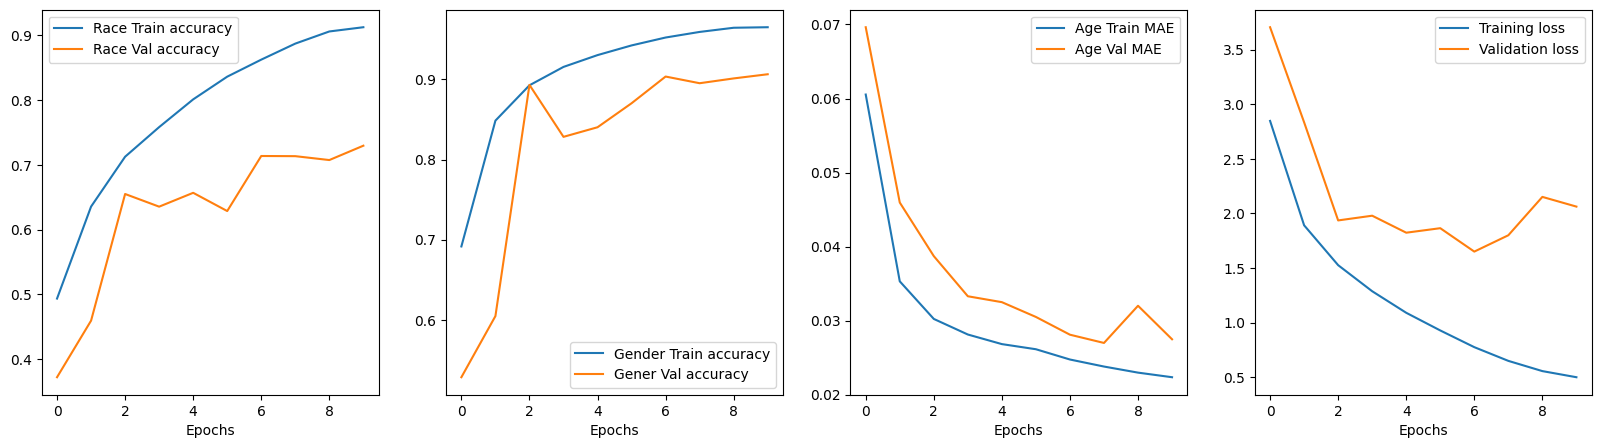

In [24]:
def  plot_train_history(history):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].plot(history.history['race_output_accuracy'], label='Race Train accuracy')
    axes[0].plot(history.history['val_race_output_accuracy'], label='Race Val accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()

    axes[1].plot(history.history['gender_output_accuracy'], label='Gender Train accuracy')
    axes[1].plot(history.history['val_gender_output_accuracy'], label='Gener Val accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

    axes[2].plot(history.history['age_output_loss'], label='Age Train MAE')
    axes[2].plot(history.history['val_age_output_loss'], label='Age Val MAE')
    axes[2].set_xlabel('Epochs')
    axes[2].legend()

    axes[3].plot(history.history['loss'], label='Training loss')
    axes[3].plot(history.history['val_loss'], label='Validation loss')
    axes[3].set_xlabel('Epochs')
    axes[3].legend()

plot_train_history(history)

In [25]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
dict(zip(model.metrics_names, model.evaluate_generator(test_gen, steps=len(test_idx)//128)))

<ipython-input-25-d6456e542e93>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  dict(zip(model.metrics_names, model.evaluate_generator(test_gen, steps=len(test_idx)//128)))


{'loss': 2.079470157623291,
 'age_output_loss': 0.029187357053160667,
 'race_output_loss': 1.1718741655349731,
 'gender_output_loss': 0.2632843852043152,
 'age_output_mae': 0.13877986371517181,
 'race_output_accuracy': 0.7376453280448914,
 'gender_output_accuracy': 0.9106104373931885}

In [26]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
x_test, (age_true, race_true, gender_true)= next(test_gen)
age_pred, race_pred, gender_pred = model.predict_on_batch(x_test)

In [27]:
race_true, gender_true = race_true.argmax(axis=-1), gender_true.argmax(axis=-1)
race_pred, gender_pred = race_pred.argmax(axis=-1), gender_pred.argmax(axis=-1)
age_true = age_true * max_age
age_pred = age_pred * max_age

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
print("Classification report for race")
print(classification_report(race_true, race_pred))

print("\nClassification report for gender")
print(classification_report(gender_true, gender_pred))

Classification report for race
              precision    recall  f1-score   support

           0       0.79      0.94      0.86        48
           1       0.75      0.92      0.83        26
           2       0.77      0.81      0.79        21
           3       0.76      0.65      0.70        20
           4       0.00      0.00      0.00        13

    accuracy                           0.77       128
   macro avg       0.62      0.66      0.64       128
weighted avg       0.69      0.77      0.73       128


Classification report for gender
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        62
           1       0.94      0.94      0.94        66

    accuracy                           0.94       128
   macro avg       0.94      0.94      0.94       128
weighted avg       0.94      0.94      0.94       128



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
print("Matrix confusion for race")
print(confusion_matrix(race_true, race_pred))
print("Matrix confusion for gender")
print(confusion_matrix(gender_true, gender_pred))

Matrix confusion for race
[[45  2  1  0  0]
 [ 1 24  0  1  0]
 [ 1  2 17  1  0]
 [ 4  1  2 13  0]
 [ 6  3  2  2  0]]
Matrix confusion for gender
[[58  4]
 [ 4 62]]


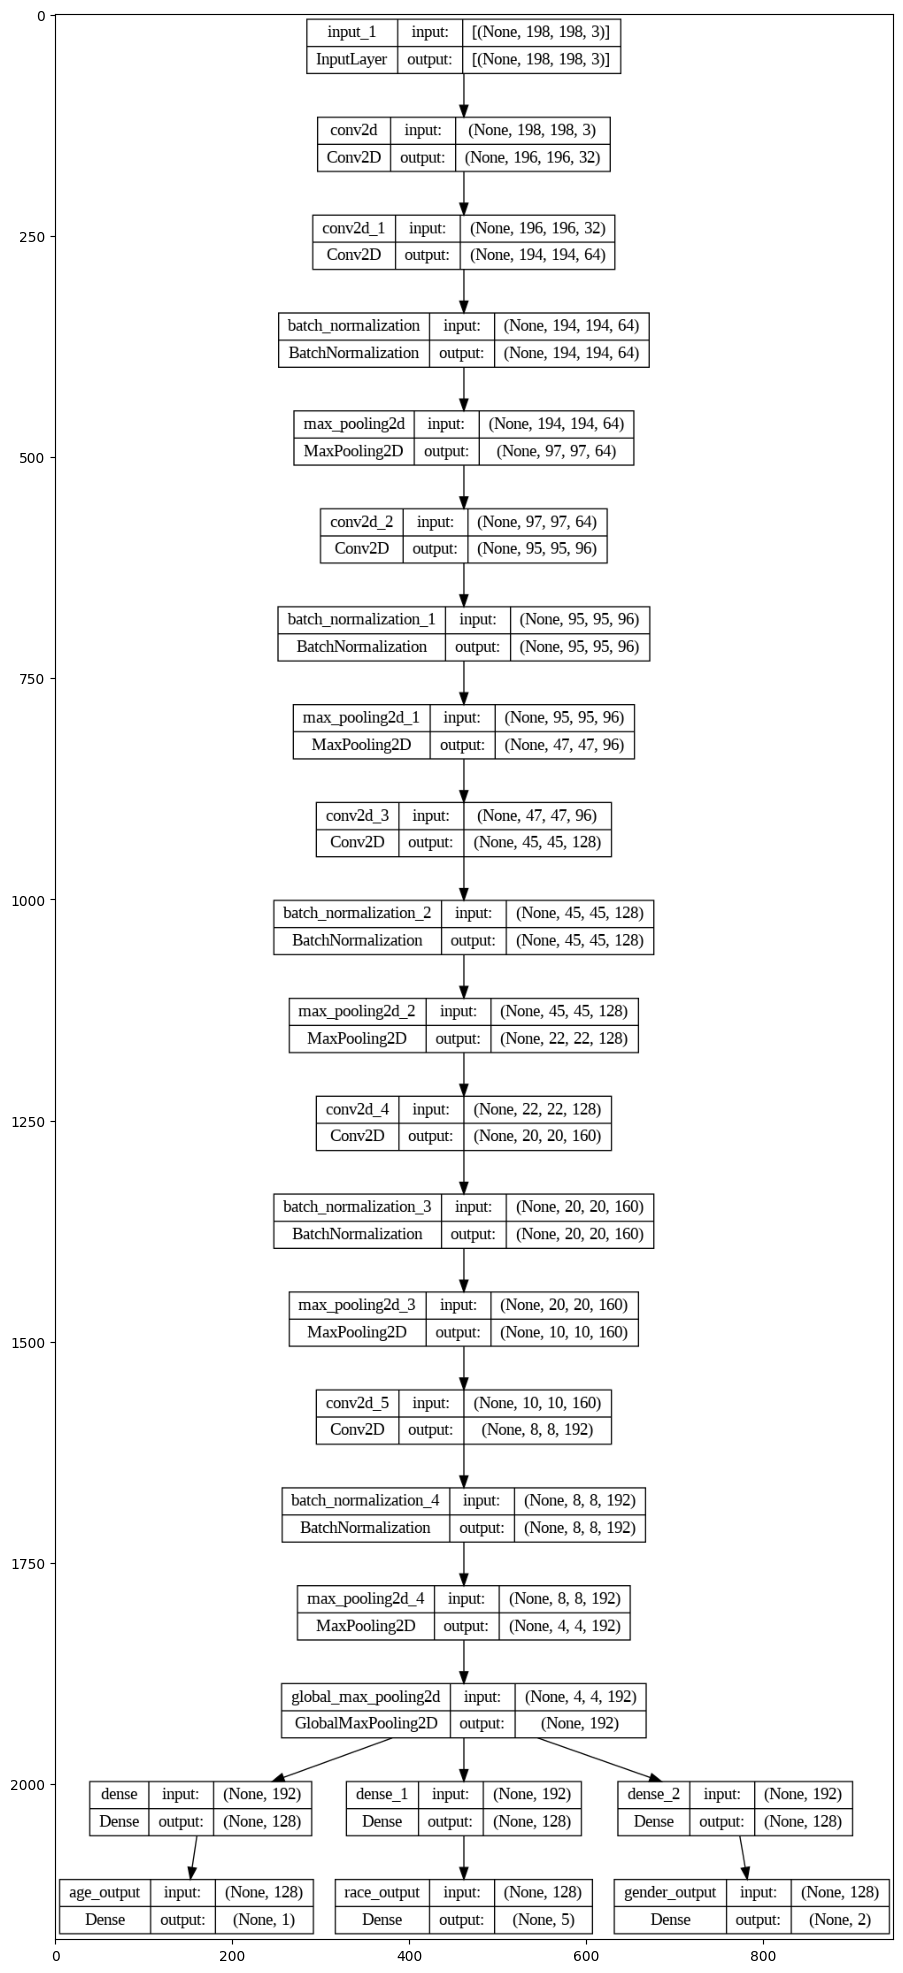

In [30]:
from keras.utils import plot_model
import matplotlib.pyplot as plt

# Visualize the model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Display the image
img = plt.imread('model_plot.png')
plt.figure(figsize=(15, 25))
plt.imshow(img)
plt.show()